# DSA4212 Assignment 1: Starter Kit

In [10]:
import numpy as np
## Progress bar
from tqdm.auto import tqdm
import pylab as plt
import copy
import time

In [11]:
if 'google.colab' in str(get_ipython()):
  print("All ok -- code is running on a Google Colab")
else:
    print("==="*15, " WARNING ","==="*15)
    print("For DSA4212 assignment 1, code needs to be run on a Google Colab with a single GPU")
    print("==="*15, " WARNING ","==="*15)



All ok -- code is running on a Google Colab


In [12]:
!nvidia-smi -L
!lscpu |grep 'Model name'
!free -h --si | awk  '/Mem:/{print $2}'

GPU 0: Tesla T4 (UUID: GPU-c56cd44f-06ae-74b1-7ef1-3149c58918eb)
Model name:                      Intel(R) Xeon(R) CPU @ 2.20GHz
12G


# Connect to Google Drive & Load data

In [13]:
# mount the Google Drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
%pwd

'/content/drive/My Drive/dataset/DSA4212/assignment_1'

In [15]:
# goto to data folder -- you may need to change this location
%cd /content/drive/MyDrive/dataset/DSA4212/assignment_1/

/content/drive/MyDrive/dataset/DSA4212/assignment_1


In [16]:
class_names=["fish", "dog", "device", "chainsaw", "church", "horn", "truck", "petrol", "golf", "parachute"]

# load data -- be patient, does take a few secs
data_train_all = np.load("assignment_1_train.npz")
data_test = np.load("assignment_1_test.npz")

X_train_all = data_train_all["img"].astype(np.float32) / 255.   # set pixel intensities to [0,1]
X_test = data_test["img"].astype(np.float32) / 255.
Y_train_all = data_train_all["label"].astype(int)
Y_test = data_test["label"].astype(int)

_,H,W,C = X_train_all.shape
print(f"Img Shape: {H}x{W}x{C}")

Img Shape: 128x128x3


In [17]:
len(X_test)

3856

In [18]:
# shuffle the train set
indices_shuffled = np.arange(len(X_train_all))
np.random.shuffle(indices_shuffled)
X_train_all = X_train_all[indices_shuffled]
Y_train_all = Y_train_all[indices_shuffled]

# shuffle the validation set
indices_shuffled = np.arange(len(X_test))
np.random.shuffle(indices_shuffled)
X_test = X_test[indices_shuffled]
Y_test = Y_test[indices_shuffled]

In [19]:
sz_train = X_train_all.size * X_train_all.itemsize / 2.**30
sz_val = X_test.size * X_test.itemsize / 2.**30

print(f"Training Set Size: {sz_train:2.2f} Go")
print(f"Validaton Set Size: {sz_val:2.2f} Go")

Training Set Size: 1.70 Go
Validaton Set Size: 0.71 Go


# Split Train / Validation / Test

The test set can only be used for the final evaluation of the model: one cannot use the test set when tuning the models. Consequently, we are going to split `X_train_all` into a train-set and a validation-set.

In [20]:
len_train_all = len(X_train_all)
len_train = int(0.8 * len_train_all)
len_val = len_train_all - len_train
len_test = len(X_test)

X_train = X_train_all[:len_train]
Y_train = Y_train_all[:len_train]

X_val = X_train_all[len_train:]
Y_val = Y_train_all[len_train:]


# Sanity checks
Let us make sure that the data is all ok

Text(0.5, 1.0, 'Pixel Intensity')

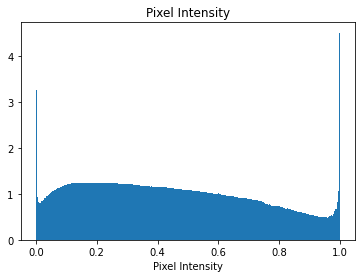

In [21]:
# histogram of pixel intensities
_ = plt.hist(X_train.ravel(), bins=256, density=True)
plt.xlabel("Pixel Intensity")
plt.title("Pixel Intensity")

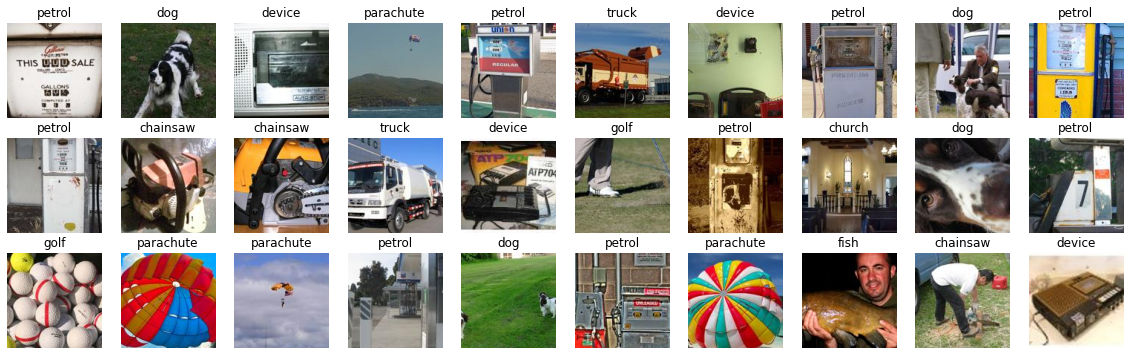

In [22]:
# train set:: sanity check
# plt a few random images in the trainset as well as their label
plt.figure( figsize=(10*2,3*2) )
for k in range(3*10):
    index = np.random.randint(low=0, high=len(X_train))
    plt.subplot(3,10,k+1)
    plt.axis("off")
    plt.imshow(X_train[index,:,:,:])
    plt.title(class_names[Y_train[index]])

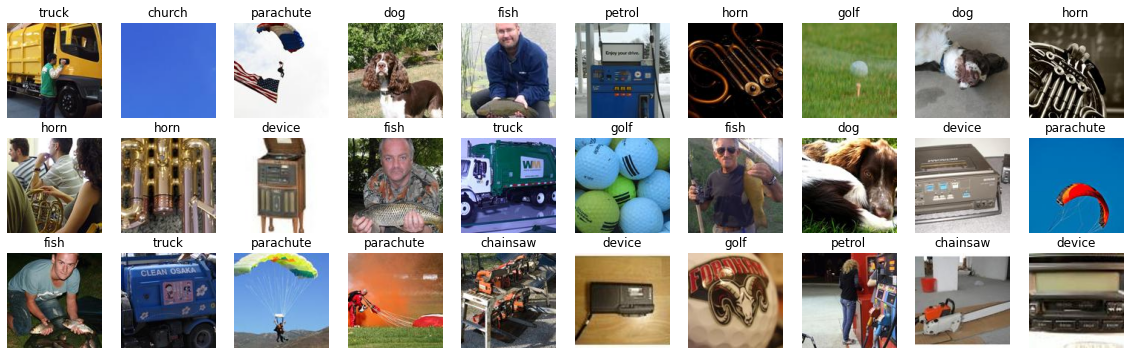

In [23]:
# validation set:: sanity check
# plt a few images as well as their label
plt.figure( figsize=(10*2,3*2) )
for k in range(3*10):
    index = np.random.randint(low=0, high=len(X_val))
    plt.subplot(3,10,k+1)
    plt.axis("off")
    plt.imshow(X_val[index,:,:,:])
    plt.title(class_names[Y_val[index]])

In [24]:
# load FLAX and install it if not installed already
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax

import flax
from flax import linen as nn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.2/214.2 KB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.2/74.2 KB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 107.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.7/238.7 KB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 KB 11.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.


In [25]:
import jax
import jax.numpy as jnp
from typing import Any, Sequence

try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

# Initial Given Model (Test Acc: 67 - 70%)

In [26]:
class LayerNorm(nn.Module):
    """
    input:
    ======
     x: tensor with D channels of dimension (B,H,W,D)
     
    output:
    ======
     x_normalized: tensor with D channels of dimension (B,H,W,D)
     
     
    Description:
    ===========
    for each each element `i` and each dimension `d`,
    normalize the 2D array x[i,:,:,d] by substracting its mean and divide by its standard deviation
       x_normalized[i,:,:,d] = (x[i,:,:,d] - mean) / stdev
    """
    @nn.compact
    def __call__(self, inputs):
        eps = 10**-3
        mean = jnp.expand_dims(jnp.mean(inputs, axis=(1,2)), axis=(1,2))
        std = jnp.expand_dims(jnp.std(inputs, axis=(1,2)), axis=(1,2))
        return (inputs - mean) / (eps + std)

class SimpleCNN(nn.Module):
    """ a simple convolutional neural network """
    n_filters: Sequence[int]  # sequence -- number of CNN filters in each layer
    n_class: int              # number of possible classes
    
    @nn.compact
    def __call__(self, x):
        """
        inputs:
        ======
         inputs: batch of images of dimension (X,H,W,3)

        outputs:
        ======
         probas: predictive probability vector
        """
        
        # convolutional layers + normalization
        for i, feat_dim in enumerate(self.n_filters):
            x = LayerNorm()(x)
            x = nn.elu( nn.Conv(features=feat_dim, kernel_size=(3,3), strides = 2, padding='SAME', name=f'layers_{i}_1')(x) )
            
        # pooling -- average across the dimension (1,2)
        x =  x.mean(axis=(1,2))
        
        # last dense layer
        x = nn.Dense(self.n_class)(x)
        
        #convert to proba
        probas = nn.softmax(x)
        return probas

In [27]:
# generate a random generator "key" that is used to initialize the net parameters
key = jax.random.PRNGKey(0)
net = SimpleCNN(n_filters=[32,64, 128], n_class = 10)

# to initialize the network, one needs to propagate some data through it
# and provide with a RNG key
key, key_ = jax.random.split(key)
batch_size = 32
batch_of_images = X_train[:batch_size,:,:,:]
params_init = net.init(key_, batch_of_images)

# count the number of parameters
param_count = sum(x.size for x in jax.tree_util.tree_leaves(params_init))
print(f"Number of Neural Parameters: {param_count//1000}k")

Number of Neural Parameters: 94k


In [28]:
@jax.jit
def loss(params, x, y):
  """ cross-entropy loss
  inputs:
  ======
   params: neural network weights
   x: (B,H,W,3) -- batch of images
   y: (B) -- labels
  """
  n_class = 10

  # compute Cross-Entropy
  pred = net.apply(params, x)
  y_hot = jax.nn.one_hot(y, n_class)
  CEs = -jnp.sum(y_hot * jnp.log(pred), axis=1)
  return jnp.mean(CEs)

# generate the gradient function
loss_value_and_grad = jax.jit( jax.value_and_grad(loss) )

In [29]:
@jax.jit
def prediction_class(params, x):
  """ make a prediction """
  pred = net.apply(params, x)
  pred_class = jnp.argmax(pred, axis=1)
  return pred_class

@jax.jit
def accuracy(params, x, y):
  """
  compute the accuracy on a batch of images

  inputs:
  ======
   params: neural network weights
   x: (B,H,W,3) -- batch of images
   y: (B) -- labels
  """
  n_class = 10

  # compute Cross-Entropy
  pred_class = prediction_class(params, x)
  return jnp.mean(pred_class == y)

# generate the gradient function
loss_value_and_grad = jax.jit( jax.value_and_grad(loss) )

In [30]:
# let us randomize the weights again to start from scratch
params = copy.deepcopy(params_init)

#define the ADAM optimizer
optimizer = optax.adam(learning_rate=0.01, eps=0.001)

#generate the initial state of the optimizer
opt_state = optimizer.init(params)

In [31]:
# put data to GPU
X_train = jax.device_put(X_train)
X_val = jax.device_put(X_val)


In [32]:
niter = 1000
batch_size = 512

# save the train loss
loss_train_history = []
loss_train_history_time = []

# save the validation loss
loss_val_history = []
loss_val_history_time = []

# save accuracies
accuracies_history = []
accuracies_history_time = []

time_start = time.time()
for k in tqdm( range(niter) ):
  # create a batch
  indices = jnp.arange(k*batch_size, (k+1)*batch_size) % len(X_train)
  X_batch = X_train[indices]
  Y_batch = Y_train[indices]

  # compute loss and gradients
  loss_train, grads = loss_value_and_grad(params, X_batch, Y_batch)
  time_elapsed = time.time() - time_start

  if k % 50 == 0:
    # compute the validation accuracy on a batch only (to save a bit of time)
    N = 512
    acc_val = 100*accuracy(params, X_val[:N], Y_val[:N])
    acc_train = 100*accuracy(params, X_train[:N], Y_train[:N])
    nb_epoch = float(k+1)*batch_size / len(X_train)
    accuracies_history.append([acc_train, acc_val])
    accuracies_history_time.append(time_elapsed)

    # also compute test loss
    loss_val = loss(params, X_val[:N], Y_val[:N])
    loss_val_history.append( loss_val )
    loss_val_history_time.append( time_elapsed )

    print(f"Time:{time_elapsed:3.1f}sec \t Epoch:{nb_epoch:2.1f} \t Loss [{loss_train:2.2f} / {loss_val:2.2f}] \t Accuracy Train/Valid: [{acc_train:2.2f}% / {acc_val:2.2f}%]")

  # generate the "update mechanism" and update the state of the optimizer
  updates, opt_state = optimizer.update(grads, opt_state, params)
  # apply the "update mechanism"
  params = optax.apply_updates(params, updates)

  #opt_state, params = do_update(grads, opt_state, params)
    
  # save the loss
  loss_train_history_time.append( time_elapsed )
  loss_train_history.append( loss_train.item() )

  0%|          | 0/1000 [00:00<?, ?it/s]

Time:9.4sec 	 Epoch:0.1 	 Loss [2.30 / 2.30] 	 Accuracy Train/Valid: [11.33% / 9.57%]
Time:21.1sec 	 Epoch:3.5 	 Loss [1.44 / 1.49] 	 Accuracy Train/Valid: [57.62% / 51.56%]
Time:25.8sec 	 Epoch:7.0 	 Loss [1.24 / 1.26] 	 Accuracy Train/Valid: [61.72% / 57.62%]
Time:30.5sec 	 Epoch:10.4 	 Loss [1.01 / 1.13] 	 Accuracy Train/Valid: [71.48% / 64.06%]
Time:35.2sec 	 Epoch:13.8 	 Loss [1.05 / 1.09] 	 Accuracy Train/Valid: [73.24% / 64.26%]
Time:40.1sec 	 Epoch:17.3 	 Loss [0.87 / 0.97] 	 Accuracy Train/Valid: [80.08% / 66.99%]
Time:44.8sec 	 Epoch:20.7 	 Loss [0.77 / 0.95] 	 Accuracy Train/Valid: [79.69% / 68.36%]
Time:49.6sec 	 Epoch:24.2 	 Loss [0.62 / 0.90] 	 Accuracy Train/Valid: [81.05% / 70.51%]
Time:54.6sec 	 Epoch:27.6 	 Loss [0.72 / 0.92] 	 Accuracy Train/Valid: [83.79% / 70.70%]
Time:59.3sec 	 Epoch:31.1 	 Loss [0.52 / 0.89] 	 Accuracy Train/Valid: [85.35% / 71.09%]
Time:64.3sec 	 Epoch:34.5 	 Loss [0.48 / 0.94] 	 Accuracy Train/Valid: [85.94% / 71.88%]
Time:69.1sec 	 Epoch:37.9 

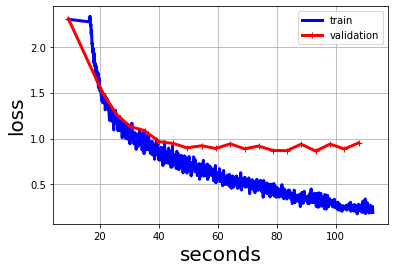

In [33]:
plt.plot(loss_train_history_time, loss_train_history, "b-", lw = 3, label="train")
plt.plot(loss_val_history_time, loss_val_history, "r-+", lw = 3, label="validation")
plt.xlabel("seconds", fontsize=20)
plt.ylabel("loss", fontsize=20)
plt.grid(True)
plt.legend()


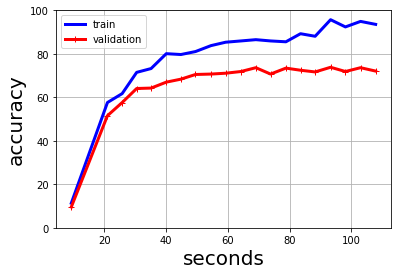

In [34]:
accuracies_history = np.array(accuracies_history)
plt.plot(accuracies_history_time, accuracies_history[:,0], "b-", lw = 3, label="train")
plt.plot(accuracies_history_time, accuracies_history[:,1], "r-+", lw = 3, label="validation")
plt.xlabel("seconds", fontsize=20)
plt.ylabel("accuracy", fontsize=20)
plt.ylim(0,100)
plt.grid(True)
plt.legend()

In [35]:
# final train accuracy
pred_train = []
n_forward_pass = len(X_train) // batch_size
for k in tqdm(range(n_forward_pass)):
  pred_train.append( prediction_class(params, X_train[k*batch_size:(k+1)*batch_size]) )
# final forward pass
pred_train.append( prediction_class(params, X_train[n_forward_pass*batch_size:]) )

pred_train = np.concatenate(pred_train)
acc_train = 100*jnp.mean(pred_train == Y_train)
print( f"Final Train Accuracy: {acc_train:2.1f}%")

  0%|          | 0/14 [00:00<?, ?it/s]

Final Train Accuracy: 94.8%


In [36]:
# final val accuracy
pred_val = []
n_forward_pass = len(X_val) // batch_size
for k in tqdm(range(n_forward_pass)):
  pred_val.append( prediction_class(params, X_val[k*batch_size:(k+1)*batch_size]) )
# final forward pass
pred_val.append( prediction_class(params, X_val[n_forward_pass*batch_size:]) )

pred_val = np.concatenate(pred_val)
acc_val = 100*jnp.mean(pred_val == Y_val)
print( f"Final val Accuracy: {acc_val:2.1f}%")

  0%|          | 0/3 [00:00<?, ?it/s]

Final val Accuracy: 70.2%


## Test Accuracy
Note we have at no point used the test-set previously.

In [37]:
# final test accuracy
pred_test = []
n_forward_pass = len(X_test) // batch_size
for k in tqdm(range(n_forward_pass)):
  pred_test.append( prediction_class(params, X_test[k*batch_size:(k+1)*batch_size]) )
# final forward pass
pred_test.append( prediction_class(params, X_test[n_forward_pass*batch_size:]) )

pred_test = np.concatenate(pred_test)
acc_test = 100*jnp.mean(pred_test == Y_test)
print( f"Final Test Accuracy: {acc_test:2.1f}%")

  0%|          | 0/7 [00:00<?, ?it/s]

Final Test Accuracy: 69.7%


# Finetuned #filters to [32, 64] and lr to 0.03 (Test Acc: 70 - 73%)

Some changes made here:

1. #filters finetuned to [32, 64]
2. lr of ADAM optimizer finetuned to 0.03
3. Increased number of iterations to 1700
4. All params after every 50 batches training are saved
5. Validation accuracy for all saved params are produced and best param is chosen
6. Best param is used to predict test dataset

In [38]:
# generate a random generator "key" that is used to initialize the net parameters
key = jax.random.PRNGKey(0)
net = SimpleCNN(n_filters=[32,64], n_class = 10)

# to initialize the network, one needs to propagate some data through it
# and provide with a RNG key
key, key_ = jax.random.split(key)
batch_size = 32
batch_of_images = X_train[:batch_size,:,:,:]
params_init = net.init(key_, batch_of_images)

# count the number of parameters
param_count = sum(x.size for x in jax.tree_util.tree_leaves(params_init))
print(f"Number of Neural Parameters: {param_count//1000}k")

Number of Neural Parameters: 20k


In [39]:
# let us randomize the weights again to start from scratch
params = copy.deepcopy(params_init)

#define the ADAM optimizer
optimizer = optax.adam(learning_rate=0.03, eps=0.001)

#generate the initial state of the optimizer
opt_state = optimizer.init(params)

In [40]:
niter = 1700
batch_size = 512

# save the train loss
loss_train_history = []
loss_train_history_time = []

# save the validation loss
loss_val_history = []
loss_val_history_time = []

# save accuracies
accuracies_history = []
accuracies_history_time = []

# save params after every 50 batches training
all_params = []

time_start = time.time()
for k in tqdm( range(niter) ):
  # create a batch
  indices = jnp.arange(k*batch_size, (k+1)*batch_size) % len(X_train)
  X_batch = X_train[indices]
  Y_batch = Y_train[indices]

  # compute loss and gradients
  loss_train, grads = loss_value_and_grad(params, X_batch, Y_batch)
  time_elapsed = time.time() - time_start

  if k % 50 == 0:
    # compute the validation accuracy on a batch only (to save a bit of time)
    N = 512
    acc_val = 100*accuracy(params, X_val[:N], Y_val[:N])
    acc_train = 100*accuracy(params, X_train[:N], Y_train[:N])
    nb_epoch = float(k+1)*batch_size / len(X_train)
    accuracies_history.append([acc_train, acc_val])
    accuracies_history_time.append(time_elapsed)

    # also compute test loss
    loss_val = loss(params, X_val[:N], Y_val[:N])
    loss_val_history.append( loss_val )
    loss_val_history_time.append( time_elapsed )

    print(f"Time:{time_elapsed:3.1f}sec \t Epoch:{nb_epoch:2.1f} \t Loss [{loss_train:2.2f} / {loss_val:2.2f}] \t Accuracy Train/Valid: [{acc_train:2.2f}% / {acc_val:2.2f}%]")

  # generate the "update mechanism" and update the state of the optimizer
  updates, opt_state = optimizer.update(grads, opt_state, params)
  # apply the "update mechanism"
  params = optax.apply_updates(params, updates)

  if k % 50 == 0:
    all_params += [params]

  #opt_state, params = do_update(grads, opt_state, params)
    
  # save the loss
  loss_train_history_time.append( time_elapsed )
  loss_train_history.append( loss_train.item() )

  0%|          | 0/1700 [00:00<?, ?it/s]

Time:1.5sec 	 Epoch:0.1 	 Loss [2.29 / 2.30] 	 Accuracy Train/Valid: [15.04% / 15.04%]
Time:6.6sec 	 Epoch:3.5 	 Loss [1.75 / 1.81] 	 Accuracy Train/Valid: [41.60% / 41.21%]
Time:10.0sec 	 Epoch:7.0 	 Loss [1.48 / 1.46] 	 Accuracy Train/Valid: [52.73% / 52.15%]
Time:13.4sec 	 Epoch:10.4 	 Loss [1.27 / 1.30] 	 Accuracy Train/Valid: [61.52% / 59.96%]
Time:16.6sec 	 Epoch:13.8 	 Loss [1.15 / 1.14] 	 Accuracy Train/Valid: [66.21% / 62.50%]
Time:20.0sec 	 Epoch:17.3 	 Loss [1.11 / 1.09] 	 Accuracy Train/Valid: [70.70% / 65.04%]
Time:23.4sec 	 Epoch:20.7 	 Loss [1.00 / 1.11] 	 Accuracy Train/Valid: [66.80% / 62.50%]
Time:26.8sec 	 Epoch:24.2 	 Loss [0.84 / 0.99] 	 Accuracy Train/Valid: [73.83% / 67.77%]
Time:30.1sec 	 Epoch:27.6 	 Loss [0.98 / 1.00] 	 Accuracy Train/Valid: [70.70% / 69.14%]
Time:33.4sec 	 Epoch:31.1 	 Loss [0.80 / 0.97] 	 Accuracy Train/Valid: [73.63% / 68.95%]
Time:36.8sec 	 Epoch:34.5 	 Loss [0.81 / 0.94] 	 Accuracy Train/Valid: [76.56% / 68.55%]
Time:40.2sec 	 Epoch:37.9 

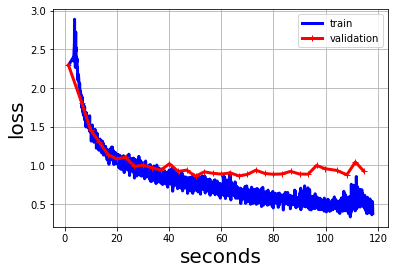

In [41]:
plt.plot(loss_train_history_time, loss_train_history, "b-", lw = 3, label="train")
plt.plot(loss_val_history_time, loss_val_history, "r-+", lw = 3, label="validation")
plt.xlabel("seconds", fontsize=20)
plt.ylabel("loss", fontsize=20)
plt.grid(True)
plt.legend()


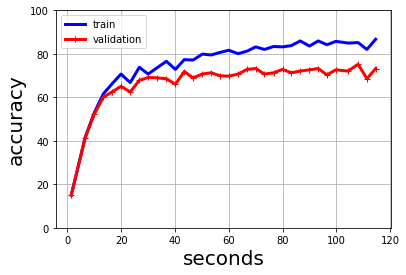

In [42]:
accuracies_history = np.array(accuracies_history)
plt.plot(accuracies_history_time, accuracies_history[:,0], "b-", lw = 3, label="train")
plt.plot(accuracies_history_time, accuracies_history[:,1], "r-+", lw = 3, label="validation")
plt.xlabel("seconds", fontsize=20)
plt.ylabel("accuracy", fontsize=20)
plt.ylim(0,100)
plt.grid(True)
plt.legend()

## Find best params

In [43]:
max_acc_val = 0
best_params = 0

for params in all_params:
    pred_val = []
    n_forward_pass = len(X_val) // batch_size
    for k in tqdm(range(n_forward_pass)):
        pred_val.append( prediction_class(params, X_val[k*batch_size:(k+1)*batch_size]) )
    # final forward pass
    pred_val.append( prediction_class(params, X_val[n_forward_pass*batch_size:]) )

    pred_val = np.concatenate(pred_val)
    acc_val = 100*jnp.mean(pred_val == Y_val)

    print(acc_val)

    if acc_val > max_acc_val:
        max_acc_val = acc_val
        best_params = params

  0%|          | 0/3 [00:00<?, ?it/s]

10.967742


  0%|          | 0/3 [00:00<?, ?it/s]

34.946236


  0%|          | 0/3 [00:00<?, ?it/s]

47.688175


  0%|          | 0/3 [00:00<?, ?it/s]

57.36559


  0%|          | 0/3 [00:00<?, ?it/s]

55.48387


  0%|          | 0/3 [00:00<?, ?it/s]

59.13979


  0%|          | 0/3 [00:00<?, ?it/s]

62.95699


  0%|          | 0/3 [00:00<?, ?it/s]

62.903225


  0%|          | 0/3 [00:00<?, ?it/s]

63.333332


  0%|          | 0/3 [00:00<?, ?it/s]

67.47312


  0%|          | 0/3 [00:00<?, ?it/s]

66.129036


  0%|          | 0/3 [00:00<?, ?it/s]

67.258064


  0%|          | 0/3 [00:00<?, ?it/s]

67.741936


  0%|          | 0/3 [00:00<?, ?it/s]

68.49462


  0%|          | 0/3 [00:00<?, ?it/s]

69.08602


  0%|          | 0/3 [00:00<?, ?it/s]

66.344086


  0%|          | 0/3 [00:00<?, ?it/s]

67.150536


  0%|          | 0/3 [00:00<?, ?it/s]

68.92473


  0%|          | 0/3 [00:00<?, ?it/s]

66.451614


  0%|          | 0/3 [00:00<?, ?it/s]

71.29033


  0%|          | 0/3 [00:00<?, ?it/s]

68.3871


  0%|          | 0/3 [00:00<?, ?it/s]

67.95699


  0%|          | 0/3 [00:00<?, ?it/s]

70.537636


  0%|          | 0/3 [00:00<?, ?it/s]

69.354836


  0%|          | 0/3 [00:00<?, ?it/s]

70.32258


  0%|          | 0/3 [00:00<?, ?it/s]

70.5914


  0%|          | 0/3 [00:00<?, ?it/s]

69.4086


  0%|          | 0/3 [00:00<?, ?it/s]

66.66667


  0%|          | 0/3 [00:00<?, ?it/s]

68.3871


  0%|          | 0/3 [00:00<?, ?it/s]

71.7742


  0%|          | 0/3 [00:00<?, ?it/s]

70.80646


  0%|          | 0/3 [00:00<?, ?it/s]

71.1828


  0%|          | 0/3 [00:00<?, ?it/s]

71.1828


  0%|          | 0/3 [00:00<?, ?it/s]

70.430115


## Train Accuracy

In [44]:
# final train accuracy
pred_train = []
n_forward_pass = len(X_train) // batch_size
for k in tqdm(range(n_forward_pass)):
  pred_train.append( prediction_class(best_params, X_train[k*batch_size:(k+1)*batch_size]) )
# final forward pass
pred_train.append( prediction_class(best_params, X_train[n_forward_pass*batch_size:]) )

pred_train = np.concatenate(pred_train)
acc_train = 100*jnp.mean(pred_train == Y_train)
print( f"Final Train Accuracy: {acc_train:2.1f}%")

  0%|          | 0/14 [00:00<?, ?it/s]

Final Train Accuracy: 85.0%


## Test Accuracy
Note we have at no point used the test-set previously.

In [45]:
# final test accuracy
pred_test = []
n_forward_pass = len(X_test) // batch_size
for k in tqdm(range(n_forward_pass)):
  pred_test.append( prediction_class(best_params, X_test[k*batch_size:(k+1)*batch_size]) )
# final forward pass
pred_test.append( prediction_class(best_params, X_test[n_forward_pass*batch_size:]) )

pred_test = np.concatenate(pred_test)
acc_test = 100*jnp.mean(pred_test == Y_test)
print( f"Final Test Accuracy: {acc_test:2.1f}%")

  0%|          | 0/7 [00:00<?, ?it/s]

Final Test Accuracy: 72.8%


# Shuffle after every epoch (Test Acc: 72 - 74 %)

Some changes made here:

1. number of batch per epoch is fixed to 15 (each batch consists of 495 or 496 rows)
2. Data will be shuffled (by shuffling the indices) after every epoch

In [46]:
# generate a random generator "key" that is used to initialize the net parameters
key = jax.random.PRNGKey(0)
net = SimpleCNN(n_filters=[32,64], n_class = 10)

# to initialize the network, one needs to propagate some data through it
# and provide with a RNG key
key, key_ = jax.random.split(key)
batch_size = 32
batch_of_images = X_train[:batch_size,:,:,:]
params_init = net.init(key_, batch_of_images)

# count the number of parameters
param_count = sum(x.size for x in jax.tree_util.tree_leaves(params_init))
print(f"Number of Neural Parameters: {param_count//1000}k")

Number of Neural Parameters: 20k


In [47]:
# let us randomize the weights again to start from scratch
params = copy.deepcopy(params_init)

#define the ADAM optimizer
optimizer = optax.adam(learning_rate=0.03, eps=0.001)

#generate the initial state of the optimizer
opt_state = optimizer.init(params)

In [48]:
niter = 1700
steps_per_epoch = 15
train_size = len(X_train)
ordering = jnp.arange(train_size)
breaks = jnp.floor(train_size/steps_per_epoch * jnp.arange(steps_per_epoch))
print(breaks)

# save the train loss
loss_train_history = []
loss_train_history_time = []

# save the validation loss
loss_val_history = []
loss_val_history_time = []

# save accuracies
accuracies_history = []
accuracies_history_time = []

# save params after every 50 batches training
all_params = []

time_start = time.time()
for k in tqdm( range(niter) ):
  
  if (k + 1) % steps_per_epoch == 0:
      ordering = jax.random.shuffle(key_, ordering)
    
  # create a batch
  indices = ordering[int(breaks[k % steps_per_epoch]): int(breaks[k % steps_per_epoch + 1])]
  X_batch = X_train[indices]
  Y_batch = Y_train[indices]

  # compute loss and gradients
  loss_train, grads = loss_value_and_grad(params, X_batch, Y_batch)
  time_elapsed = time.time() - time_start

  if k % 50 == 0:
    # compute the validation accuracy on a batch only (to save a bit of time)
    N = 512
    acc_val = 100*accuracy(params, X_val[:N], Y_val[:N])
    acc_train = 100*accuracy(params, X_train[:N], Y_train[:N])
    nb_epoch = k / steps_per_epoch
    accuracies_history.append([acc_train, acc_val])
    accuracies_history_time.append(time_elapsed)

    # also compute test loss
    loss_val = loss(params, X_val[:N], Y_val[:N])
    loss_val_history.append( loss_val )
    loss_val_history_time.append( time_elapsed )

    print(f"Time:{time_elapsed:3.1f}sec \t Epoch:{nb_epoch:2.1f} \t Loss [{loss_train:2.2f} / {loss_val:2.2f}] \t Accuracy Train/Valid: [{acc_train:2.2f}% / {acc_val:2.2f}%]")

  # generate the "update mechanism" and update the state of the optimizer
  updates, opt_state = optimizer.update(grads, opt_state, params)
  # apply the "update mechanism"
  params = optax.apply_updates(params, updates)

  if k % 50 == 0:
      all_params += [params]

  #opt_state, params = do_update(grads, opt_state, params)
    
  # save the loss
  loss_train_history_time.append( time_elapsed )
  loss_train_history.append( loss_train.item() )

[   0.  495.  991. 1487. 1982. 2478. 2974. 3470. 3965. 4461. 4957. 5453.
 5948. 6444. 6940.]


  0%|          | 0/1700 [00:00<?, ?it/s]

Time:4.8sec 	 Epoch:0.0 	 Loss [2.29 / 2.30] 	 Accuracy Train/Valid: [15.04% / 15.04%]


/usr/local/lib/python3.9/dist-packages/jax/_src/random.py:403: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
  warnings.warn(msg, FutureWarning)


Time:14.1sec 	 Epoch:3.3 	 Loss [1.87 / 1.90] 	 Accuracy Train/Valid: [41.02% / 37.89%]
Time:17.3sec 	 Epoch:6.7 	 Loss [1.67 / 1.62] 	 Accuracy Train/Valid: [52.54% / 47.07%]
Time:20.6sec 	 Epoch:10.0 	 Loss [2.56 / 2.53] 	 Accuracy Train/Valid: [31.25% / 32.62%]
Time:23.8sec 	 Epoch:13.3 	 Loss [1.31 / 1.28] 	 Accuracy Train/Valid: [60.94% / 58.20%]
Time:26.9sec 	 Epoch:16.7 	 Loss [1.19 / 1.21] 	 Accuracy Train/Valid: [65.82% / 61.33%]
Time:30.0sec 	 Epoch:20.0 	 Loss [1.24 / 1.29] 	 Accuracy Train/Valid: [56.45% / 59.38%]
Time:33.4sec 	 Epoch:23.3 	 Loss [1.30 / 1.24] 	 Accuracy Train/Valid: [60.94% / 58.40%]
Time:36.6sec 	 Epoch:26.7 	 Loss [1.03 / 1.07] 	 Accuracy Train/Valid: [72.07% / 67.58%]
Time:39.8sec 	 Epoch:30.0 	 Loss [1.16 / 1.10] 	 Accuracy Train/Valid: [65.04% / 62.30%]
Time:43.0sec 	 Epoch:33.3 	 Loss [1.11 / 1.11] 	 Accuracy Train/Valid: [66.02% / 63.48%]
Time:46.4sec 	 Epoch:36.7 	 Loss [0.95 / 0.95] 	 Accuracy Train/Valid: [73.05% / 69.34%]
Time:49.5sec 	 Epoch:40

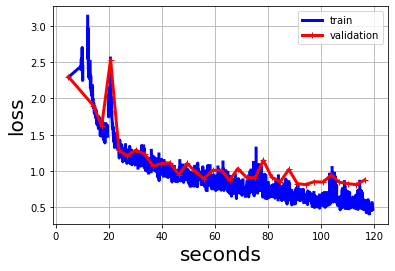

In [49]:
plt.plot(loss_train_history_time, loss_train_history, "b-", lw = 3, label="train")
plt.plot(loss_val_history_time, loss_val_history, "r-+", lw = 3, label="validation")
plt.xlabel("seconds", fontsize=20)
plt.ylabel("loss", fontsize=20)
plt.grid(True)
plt.legend()


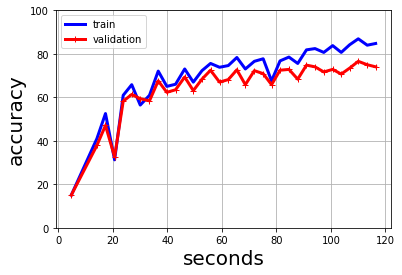

In [50]:
accuracies_history = np.array(accuracies_history)
plt.plot(accuracies_history_time, accuracies_history[:,0], "b-", lw = 3, label="train")
plt.plot(accuracies_history_time, accuracies_history[:,1], "r-+", lw = 3, label="validation")
plt.xlabel("seconds", fontsize=20)
plt.ylabel("accuracy", fontsize=20)
plt.ylim(0,100)
plt.grid(True)
plt.legend()

## Find best params

In [51]:
max_acc_val = 0
best_params = 0

for params in all_params:
    pred_val = []
    n_forward_pass = len(X_val) // batch_size
    for k in tqdm(range(n_forward_pass)):
        pred_val.append( prediction_class(params, X_val[k*batch_size:(k+1)*batch_size]) )
    # final forward pass
    pred_val.append( prediction_class(params, X_val[n_forward_pass*batch_size:]) )

    pred_val = np.concatenate(pred_val)
    acc_val = 100*jnp.mean(pred_val == Y_val)

    print(acc_val)

    if acc_val > max_acc_val:
        max_acc_val = acc_val
        best_params = params

  0%|          | 0/58 [00:00<?, ?it/s]

10.483871


  0%|          | 0/58 [00:00<?, ?it/s]

33.763443


  0%|          | 0/58 [00:00<?, ?it/s]

45.967743


  0%|          | 0/58 [00:00<?, ?it/s]

37.903225


  0%|          | 0/58 [00:00<?, ?it/s]

54.94624


  0%|          | 0/58 [00:00<?, ?it/s]

57.096775


  0%|          | 0/58 [00:00<?, ?it/s]

59.569897


  0%|          | 0/58 [00:00<?, ?it/s]

62.31183


  0%|          | 0/58 [00:00<?, ?it/s]

60.967743


  0%|          | 0/58 [00:00<?, ?it/s]

63.92473


  0%|          | 0/58 [00:00<?, ?it/s]

65.10753


  0%|          | 0/58 [00:00<?, ?it/s]

67.258064


  0%|          | 0/58 [00:00<?, ?it/s]

66.451614


  0%|          | 0/58 [00:00<?, ?it/s]

64.62366


  0%|          | 0/58 [00:00<?, ?it/s]

63.76344


  0%|          | 0/58 [00:00<?, ?it/s]

67.150536


  0%|          | 0/58 [00:00<?, ?it/s]

69.08602


  0%|          | 0/58 [00:00<?, ?it/s]

68.60215


  0%|          | 0/58 [00:00<?, ?it/s]

69.67742


  0%|          | 0/58 [00:00<?, ?it/s]

68.17204


  0%|          | 0/58 [00:00<?, ?it/s]

67.258064


  0%|          | 0/58 [00:00<?, ?it/s]

68.3871


  0%|          | 0/58 [00:00<?, ?it/s]

71.236565


  0%|          | 0/58 [00:00<?, ?it/s]

68.27957


  0%|          | 0/58 [00:00<?, ?it/s]

68.44086


  0%|          | 0/58 [00:00<?, ?it/s]

68.3871


  0%|          | 0/58 [00:00<?, ?it/s]

70.268814


  0%|          | 0/58 [00:00<?, ?it/s]

72.90323


  0%|          | 0/58 [00:00<?, ?it/s]

71.02151


  0%|          | 0/58 [00:00<?, ?it/s]

66.72043


  0%|          | 0/58 [00:00<?, ?it/s]

71.935486


  0%|          | 0/58 [00:00<?, ?it/s]

69.03226


  0%|          | 0/58 [00:00<?, ?it/s]

71.344086


  0%|          | 0/58 [00:00<?, ?it/s]

71.61291


## Train Accuracy

In [52]:
# final train accuracy
pred_train = []
n_forward_pass = len(X_train) // batch_size
for k in tqdm(range(n_forward_pass)):
  pred_train.append( prediction_class(best_params, X_train[k*batch_size:(k+1)*batch_size]) )
# final forward pass
pred_train.append( prediction_class(best_params, X_train[n_forward_pass*batch_size:]) )

pred_train = np.concatenate(pred_train)
acc_train = 100*jnp.mean(pred_train == Y_train)
print( f"Final Train Accuracy: {acc_train:2.1f}%")

  0%|          | 0/232 [00:00<?, ?it/s]

Final Train Accuracy: 82.8%


## Test Accuracy
Note we have at no point used the test-set previously.

In [53]:
# final test accuracy
pred_test = []
n_forward_pass = len(X_test) // batch_size
for k in tqdm(range(n_forward_pass)):
  pred_test.append( prediction_class(best_params, X_test[k*batch_size:(k+1)*batch_size]) )
# final forward pass
pred_test.append( prediction_class(best_params, X_test[n_forward_pass*batch_size:]) )

pred_test = np.concatenate(pred_test)
acc_test = 100*jnp.mean(pred_test == Y_test)
print( f"Final Test Accuracy: {acc_test:2.1f}%")

  0%|          | 0/120 [00:00<?, ?it/s]

Final Test Accuracy: 73.8%
